In [1]:
import torch.utils.data as data_utils
from torchvision import datasets, transforms
import torch
from transformers import AutoImageProcessor, AutoModel
import matplotlib.pylab as plt
from PIL import Image
import requests
from tqdm import tqdm

In [2]:
dataset = datasets.MNIST('../datasets',
                      train=False,
                      download=True,
                      transform=None)

In [3]:
test_results = torch.load("../model_weights/mnst_multiplier_4_transformer_t0/test_explain.pt")

In [4]:
test_results.keys()

dict_keys(['true_label', 'pred_label', 'masks', 'batch_indices', 'attention_scores'])

In [5]:
test_results["batch_indices"].shape, test_results["true_label"].shape, test_results["attention_scores"].shape, test_results["masks"].shape

(torch.Size([32000, 40]),
 torch.Size([32000]),
 torch.Size([32000, 12, 41, 41]),
 torch.Size([32000, 40]))

In [6]:
select_index = 100
test_results["batch_indices"][select_index]

tensor([7406, 7057, 6385, 6322, 6758, 6618, 4201, 1044,  656, 7971, 2950, 6301,
        4705,  480, 7262, 5634, 2138, 1724, 4037, 2318, 6468,  271, 9302, 4697,
        6266, 9516, 7235, 7090, 7988, 4878,  355, 2548,  418, 1083,  494, 2799,
        7308, 8255, 1765, 9166])

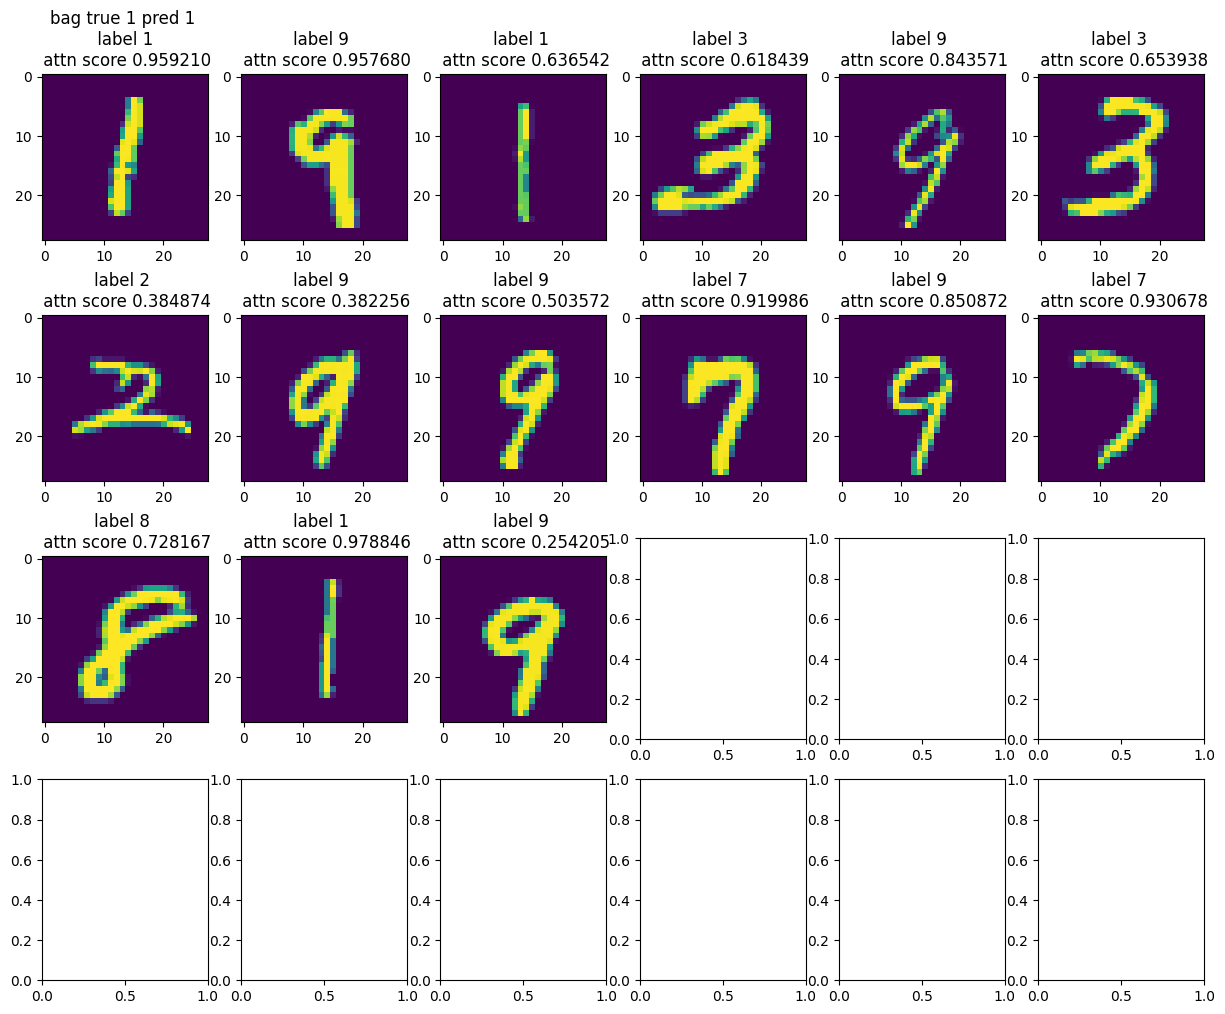

In [63]:
def transformer_attention_agg(attn, agg_fn="mean"):
    if agg_fn == "mean":
        return torch.mean(attn.view(12*41, 41), 0)[1:]
    elif agg_fn == "max":
        return torch.max(attn.view(12*41, 41), 0)[0][1:]
    elif agg_fn == "quantile":
        return torch.quantile(attn.view(12*41, 41), 0.90, 0)[1:]
    else:
        return torch.mean(attn.view(12*41, 41), 0)[1:]

def plot_scores(row, test_results):
    batch_indices = test_results["batch_indices"][row]
    imgs = [dataset[i_][0] for i_ in batch_indices]
    labels = [dataset[i_][1] for i_ in batch_indices]
    true_label = test_results["true_label"][row]
    pred_label = test_results["pred_label"][row]
    n = int(torch.sum(test_results["masks"][row]))
    n_cols = 6
    n_rows = 4
    scores = transformer_attention_agg(test_results["attention_scores"][row], agg_fn="max")
    fig, ax = plt.subplots(n_rows, n_cols)
    fig.set_figwidth(15)
    fig.set_figheight(12)
    for i in range(n):
        ax[i//n_cols][i%n_cols].imshow(imgs[i])
        if i == 0:
            ax[i//n_cols][i%n_cols].set_title("bag true %i pred %i \n label %i \n attn score %f"%(true_label, pred_label, labels[i], scores[i]))
        else:
            ax[i//n_cols][i%n_cols].set_title("label %i \n attn score %f"%(labels[i], scores[i]))
plot_scores(13, test_results)

In [64]:
# torch.where(test_results["true_label"].eq(test_results["pred_label"]) == False)

In [65]:
# torch.max(attn.view(12*41, 41), 0)